# Weather - Data Analysis

Notebook responsible to explore weather data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import time

In [2]:
def get_nan_percentual(df):
    """
    This functions is responsible for calculate the percentual of missing data and print it for each column of a dataframe.
    
    args:
    
    df (pd.DataFrame) -> Data Set to be analized
    """
    missing_values = df.isna().mean()
    length_missing_values = len(missing_values)
    
    for ind in range(length_missing_values):
        
        print(f'{missing_values.index[ind]}:>> {missing_values[ind]}%')

In [3]:
base_path = 'data\\'
weather_filename = 'weather.csv'
weather = pd.read_csv(''.join([base_path, weather_filename]), parse_dates=['Unnamed: 0'])
weather.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
weather.set_index('Date', inplace=True)

# Descriptive analysis

In [4]:
weather.describe().T

,count,mean,std,min,25%,50%,75%,max
Hs,481.0,2.439501,0.530898,1.6,2.0,2.4,2.8,3.6
Hss,481.0,2.130146,0.470622,1.3,1.7,2.1,2.5,3.2
Hsw,481.0,1.062578,0.580205,0.0,0.6,1.0,1.5,2.5
Tp,481.0,10.211019,1.926196,6.4,8.7,10.1,10.9,14.8
Tps,481.0,10.826403,2.003920,7.6,9.2,10.2,12.3,16.4
Tpw,481.0,5.849480,1.575980,0.0,5.1,6.3,6.9,8.7
DIRM,481.0,121.187110,41.875738,51.0,84.0,126.0,157.0,196.0
DIRPs,481.0,132.629938,39.769548,67.0,101.0,124.0,167.0,209.0
DIRPw,481.0,113.261954,73.140062,0.0,43.0,117.0,161.0,359.0


In [5]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 481 entries, 2020-08-15 00:00:00+00:00 to 2020-09-04 00:00:00+00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hs      481 non-null    float64
 1   Hss     481 non-null    float64
 2   Hsw     481 non-null    float64
 3   Tp      481 non-null    float64
 4   Tps     481 non-null    float64
 5   Tpw     481 non-null    float64
 6   DIRM    481 non-null    float64
 7   DIRPs   481 non-null    float64
 8   DIRPw   481 non-null    float64
dtypes: float64(9)
memory usage: 37.6 KB


In [6]:
columns_without_date = [col for col in weather.columns if col != 'Date']
weather.loc[:, columns_without_date] = weather.loc[:, columns_without_date].astype('float32')

In [7]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 481 entries, 2020-08-15 00:00:00+00:00 to 2020-09-04 00:00:00+00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Hs      481 non-null    float32
 1   Hss     481 non-null    float32
 2   Hsw     481 non-null    float32
 3   Tp      481 non-null    float32
 4   Tps     481 non-null    float32
 5   Tpw     481 non-null    float32
 6   DIRM    481 non-null    float32
 7   DIRPs   481 non-null    float32
 8   DIRPw   481 non-null    float32
dtypes: float32(9)
memory usage: 20.7 KB


__Conclusions:__

- All numerical data was read as `float64`, to use less memory, it is interesting to change the column type to a more economical float. In this case, changing to `float32` reduced memory usage from `37.7MB` to `20.8MB`.

# Nan analysis

In [8]:
get_nan_percentual(weather)

Hs:>> 0.0%
Hss:>> 0.0%
Hsw:>> 0.0%
Tp:>> 0.0%
Tps:>> 0.0%
Tpw:>> 0.0%
DIRM:>> 0.0%
DIRPs:>> 0.0%
DIRPw:>> 0.0%


__Conclusions:__

There's no missing values.

# Dynamic Analysis

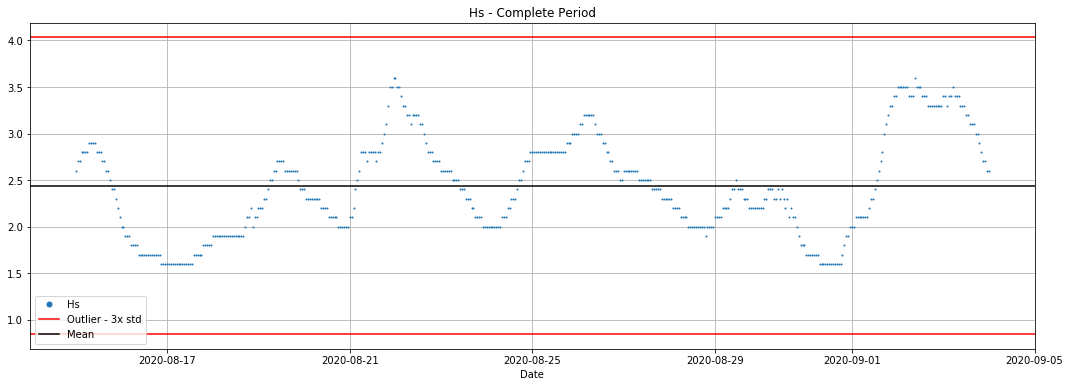

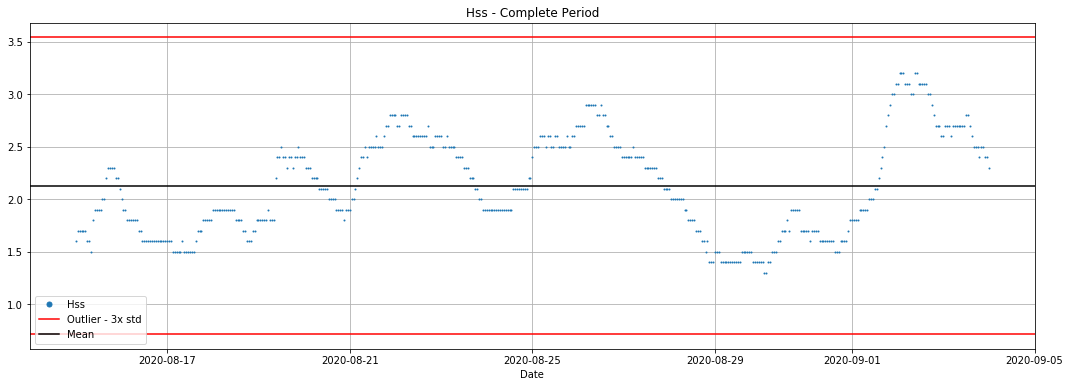

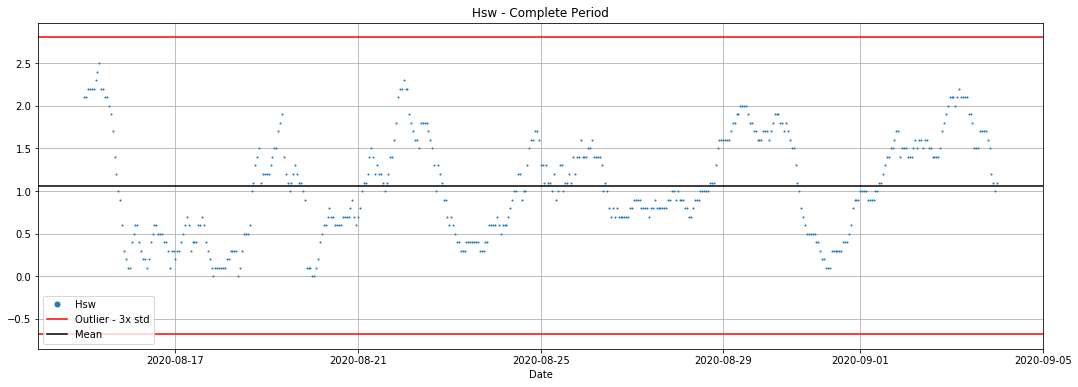

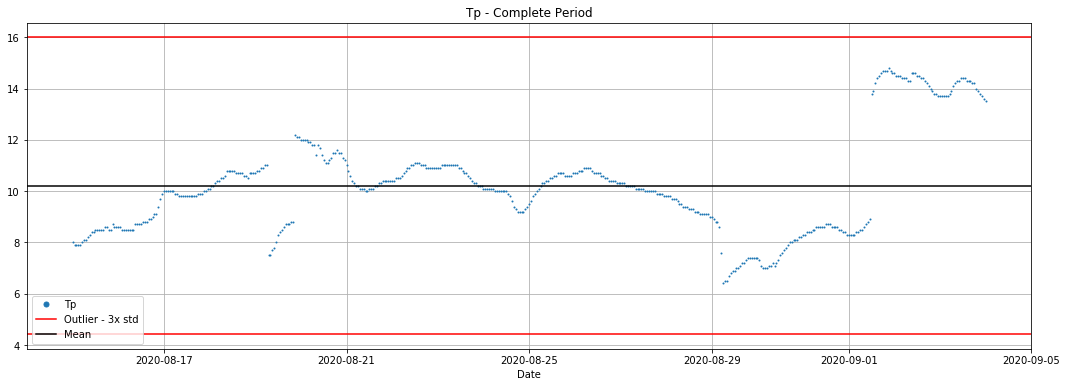

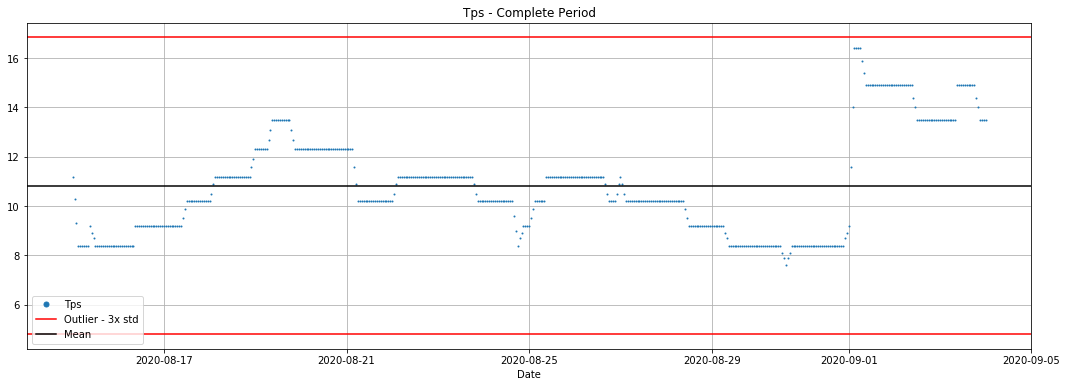

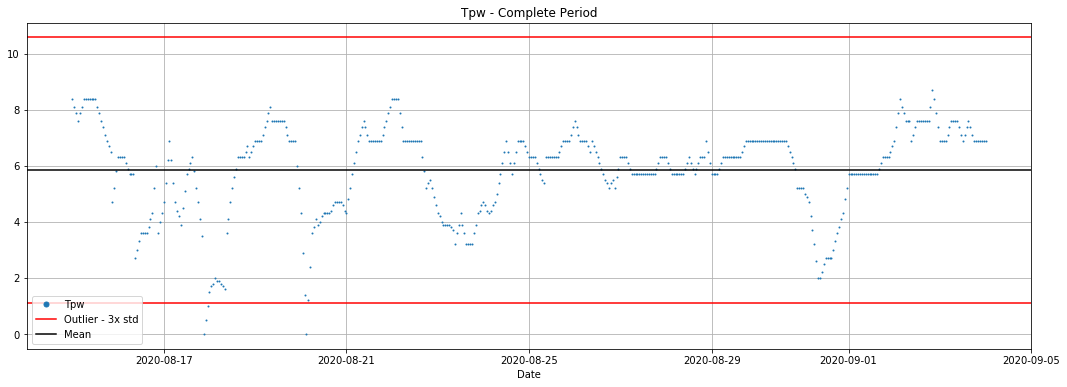

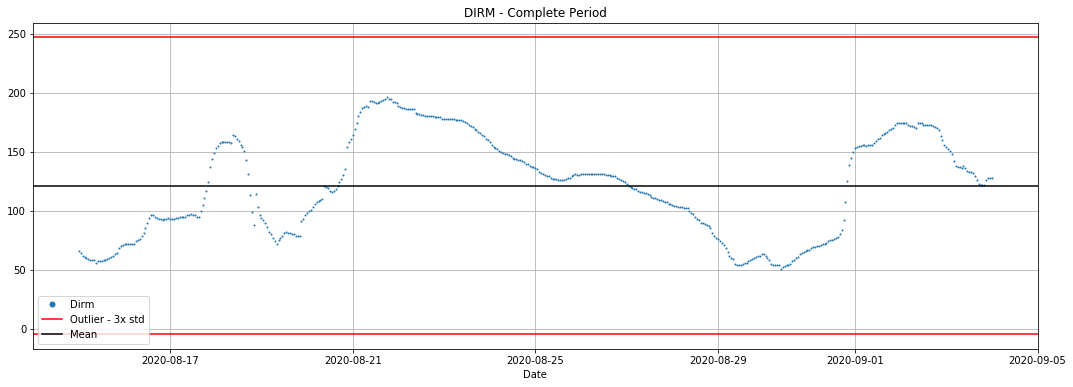

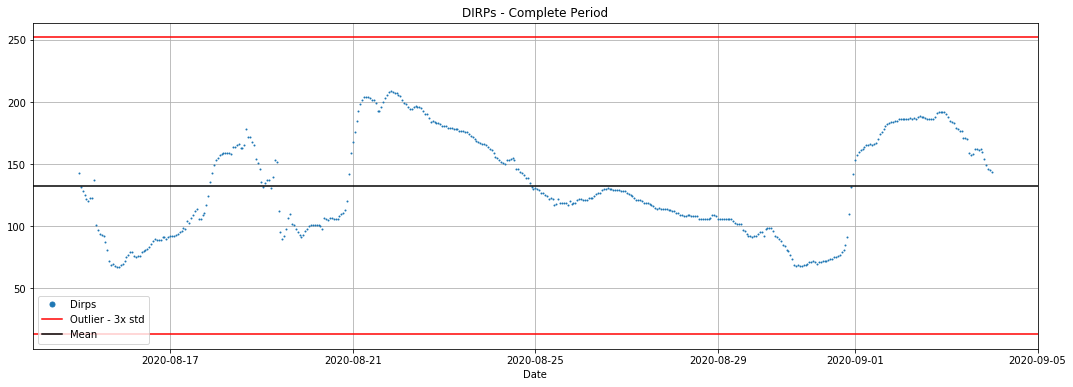

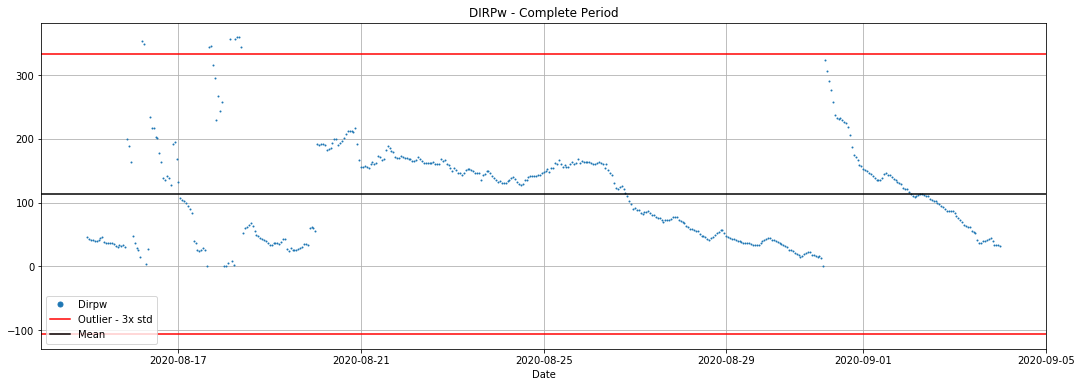

In [9]:
for column in columns_without_date:
    plt.figure(figsize = (18, 6))
    plt.grid()
    plt.title(f'{column} - Complete Period')
    plt.plot(weather[column], 'o', ms = 1, label=column.lower().capitalize())
    mean = weather[column].mean()
    std = weather[column].std()
    plt.axhline(y=mean + 3* std, c='r', label='Outlier - 3x std')
    plt.axhline(y=mean - 3* std, c='r')
    plt.axhline(y=mean, c='k', label='Mean')
    plt.xlabel('Date')
    plt.legend(loc='lower left', markerscale=5)
    plt.show()

__Conclusions:__
    
- This analysis was important to observe the dynamic behavior of each weather feature.
- The dynamic behavior seems to have a continuous characteristic, which favors the premise of using interpolation to increase the number of entries in the data set.
- For the analysis of outliers, the criterion of 3x the standard deviation was used. Few points were observed outside this range. So at this point these points have not been eliminated.

# Creating an interpolated dataset:

The idea of interpolation is to create a number of points that make it possible to synchronize weather data with the vessel response data, without losing its oscillatory behavior.

__Procedure:__

__1)__ Create a new dataset with the same time range of weather data but with interval of one second from one point to another.\
__2)__ Fill the entries with real data when the indices coincide.\
__3)__ Fill nan with linear interpolation.\
__4)__ Plot the new data to observe the dynamic behavior.\
__5)__ Save the new data set for later use.

In [10]:
import pandas as pd

class InterpolatedDataGenerator(object):
    
    def __init__(self, min_date, max_date, original_df, freq):
        """
        Object used to create interpolated datasets based on an original one. The method consist in used a frequency of time to
        create a new dataset allocating the original data into the right place. After that an interpolation method is applied.
        
        Parameters
        ----------
        min_date (str or datetime) -> Date used as start to create an interpolated dataset.
        max_date (str or datetime) -> Date used as end to create an interpolated dataset.
        original_df (pd.DataFrame) -> Original dataset used to create an interpolated new one.
        freq (str) -> Frequency of time used to generate a new dataset.
        
        """
        self.min_date = min_date
        self.max_date = max_date
        self.original_df = original_df.copy()
        self.freq = freq
        self.new_df = self.generate_df_with_new_date_index()
        self.fill_new_df_with_original_data()
    
    def generate_df_with_new_date_index(self):
        """
        this method create a new dataset with the same columns of the original but considering a new frequency of time.
        
        """
        
        if self.original_df.index.dtype != 'datetime64[ns, UTC]':
            
            raise TypeError('Define the original df index to be a datetime64[ns, UTC] type')
        
        name = self.original_df.index.name
        columns = self.original_df.columns
        date_index = pd.date_range(start=self.min_date, end=self.max_date, name=name, freq=self.freq)
        new_df = pd.DataFrame(columns=columns, index=date_index)
        return new_df
    
    def fill_new_df_with_original_data(self):
        """
        This method relates the data from the original dataset to the new dataset, filling in the values
        where the dates coincide.
        
        """
        self.new_df.loc[self.original_df.index, self.original_df.columns] = self.original_df
        self.new_df = self.new_df.astype('float32', errors='ignore')
        
    def interpolate_data(self, method='linear'):
        """
        Method used to generate interpolated dataset based on a new dataset generated using a given time frequency.
        
        """
        interpolated_df = self.new_df.interpolate(method)
        return interpolated_df
    
    def __str__(self):
        
        return f'Start Date: {self.min_date} - End Date: {self.max_date} - Time frequency: {"Second" if self.freq == "S" else self.freq}'
    
    def __repr__(self):
        
        return f'InterpolatedDataGenerator({self.min_date}, {self.max_date}, original_df, {self.freq})'

In [11]:
# Remember to verify if the dates are in the weather index.

min_date = weather.index.min()
max_date = weather.index.max()

interpolated_generator = InterpolatedDataGenerator(min_date, max_date, original_df=weather, freq='S')
weather_interpolated = interpolated_generator.interpolate_data(method='linear')

# Plot entries from interpolated dataset.

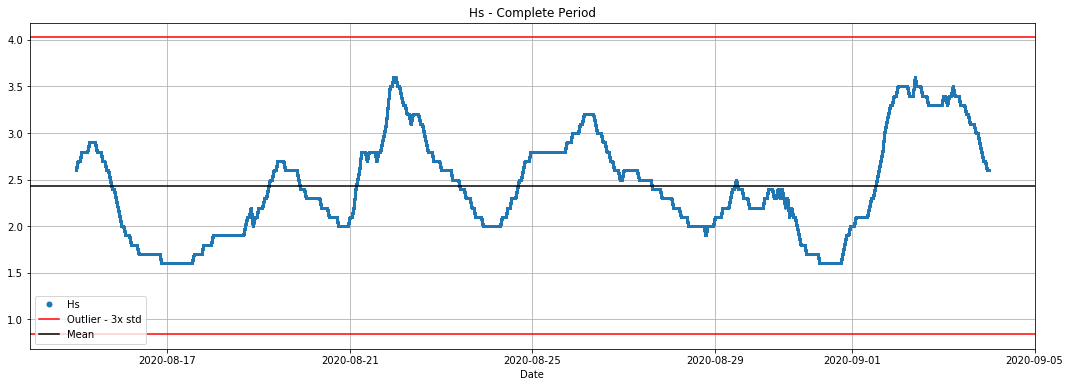

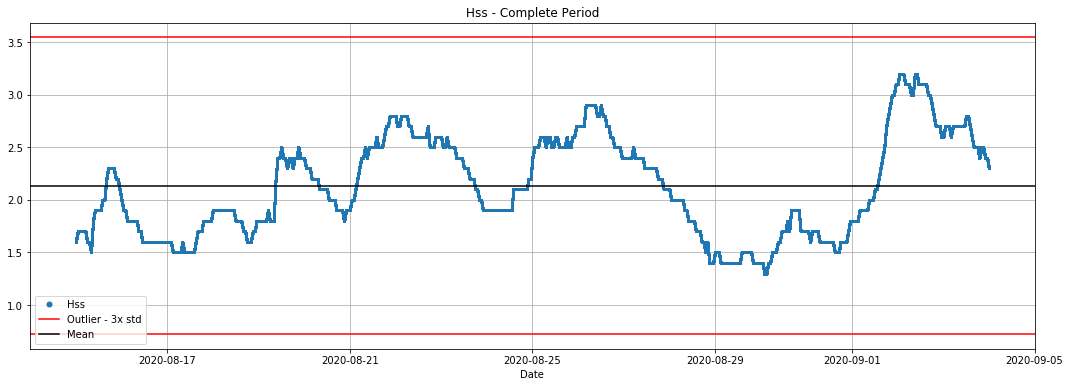

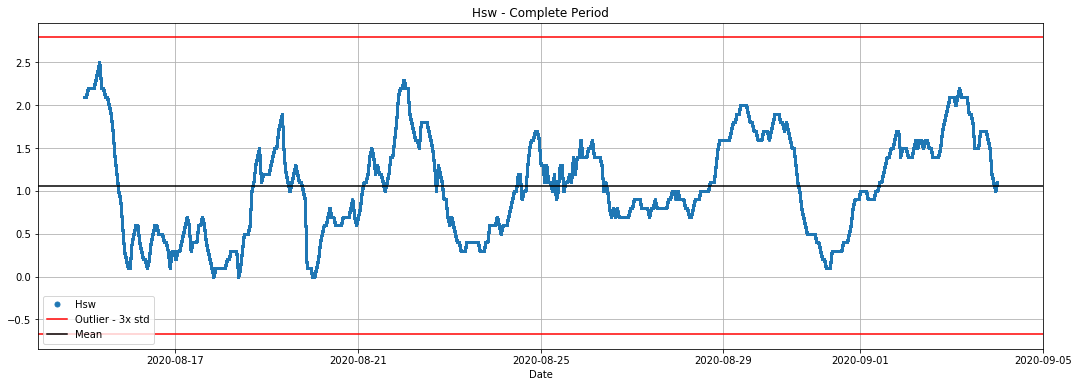

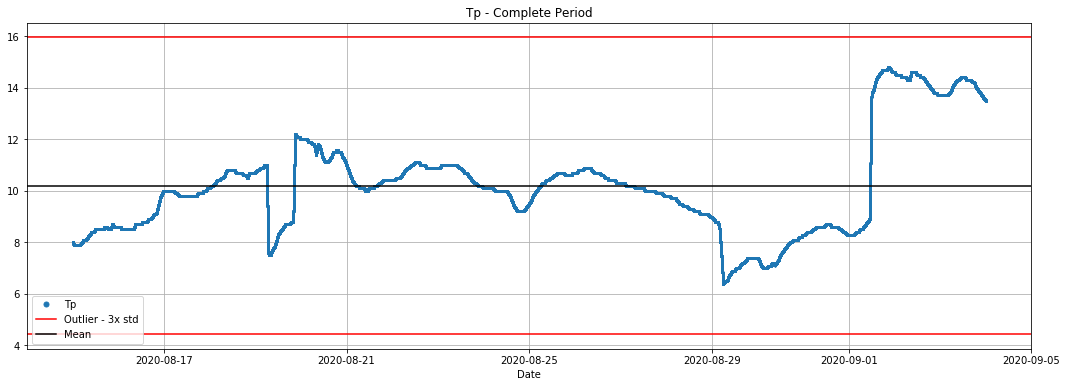

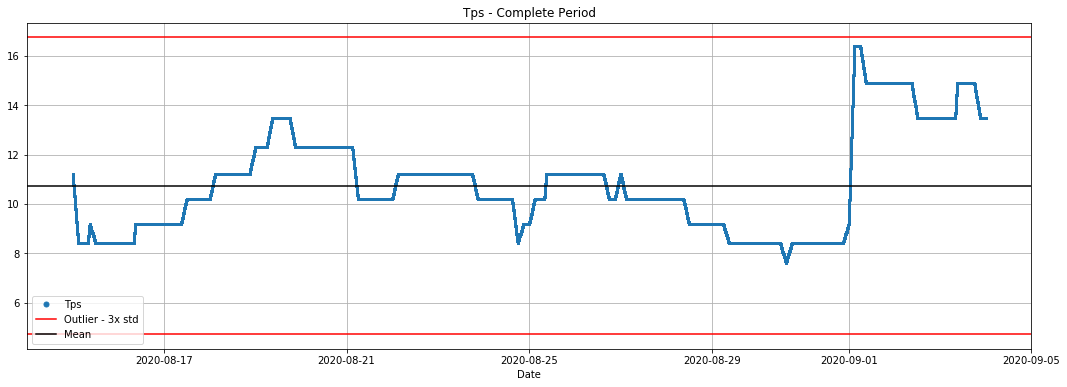

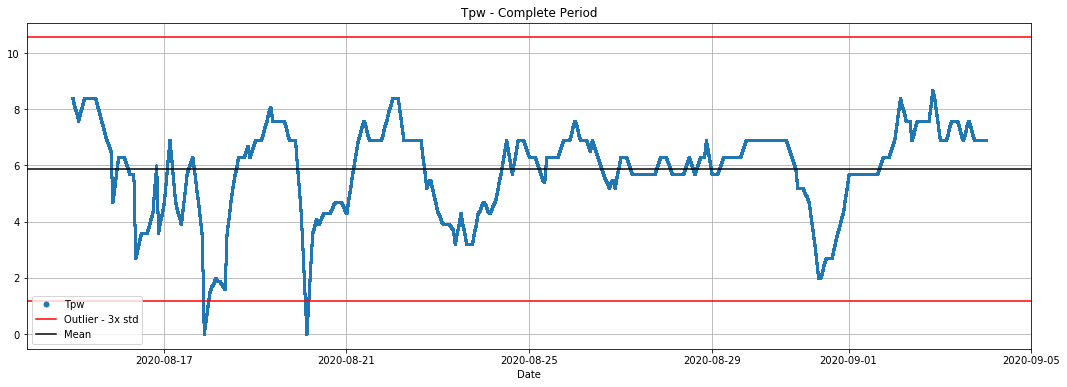

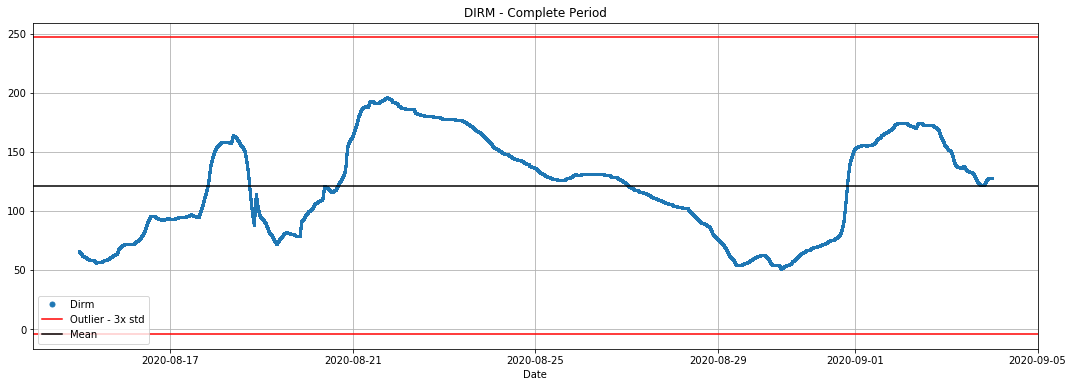

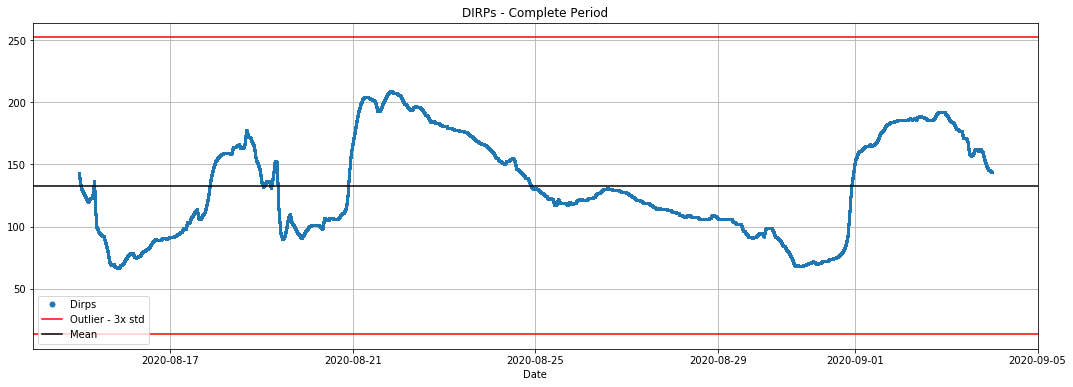

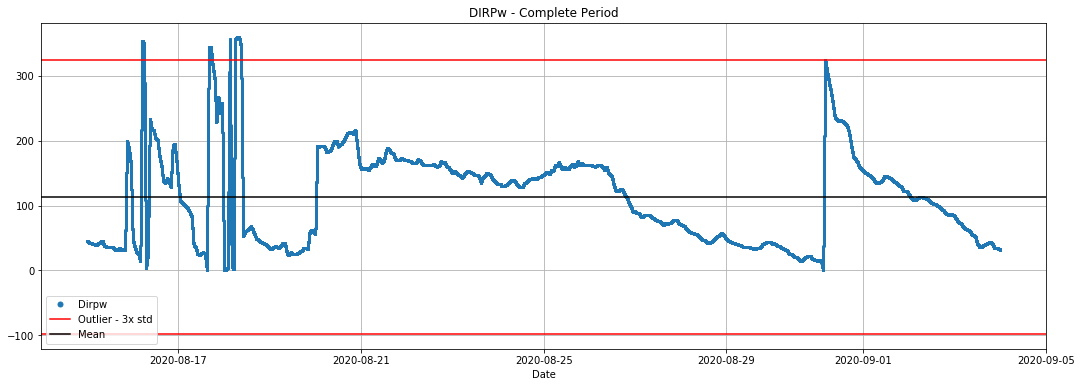

In [12]:
for column in columns_without_date:
    plt.figure(figsize = (18, 6))
    plt.grid()
    plt.title(f'{column} - Complete Period')
    plt.plot(weather_interpolated[column], 'o', ms = 1, label=column.lower().capitalize())
    mean = weather_interpolated[column].mean()
    std = weather_interpolated[column].std()
    plt.axhline(y=mean + 3* std, c='r', label='Outlier - 3x std')
    plt.axhline(y=mean - 3* std, c='r')
    plt.axhline(y=mean, c='k', label='Mean')
    plt.xlabel('Date')
    plt.legend(loc='lower left', markerscale=5)
    plt.show()

__conclusions:__

As previously mentioned, the choice of linear interpolation was made due to the dynamic profile of the features. When plotting the interpolated dataset, it is observed that most features maintain a well-behaved profile.
Features `Tp` and `Tps` reach levels not previously observed, it is necessary to investigate in this case. What may have happened to cause this variation.\
Feature `DIRPw` presents a period of great instability at the beginning.\
In the modeling stage, the influence of these features will be better evaluated.

# Saving an interpolated dataset.

In [13]:
interpolated_filename = 'weather_interpolated.csv'
weather_interpolated.to_csv(''.join([base_path, interpolated_filename]))